In [ ]:
!tar -xf /content/drive/MyDrive/Datasets/bg-clot.tar.xz

In [ ]:
import os
import random
import glob
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as T
import pytorch_lightning as pl
import torchmetrics
from typing import List, Tuple

def seed_everything(seed: int = 0):
    pl.seed_everything(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything()

INFO:lightning_fabric.utilities.seed:Global seed set to 0


0

In [ ]:
train_transforms = T.Compose([
    T.Resize((128, 128)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.4),
    T.RandomRotation(degrees=(0, 90)),
    T.RandomAdjustSharpness(sharpness_factor=2),
    T.RandomAutocontrast(),
    T.RandomApply([
        T.Grayscale(num_output_channels=3),
        T.ColorJitter(brightness=.5, hue=.3),
        T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        T.RandomEqualize()
    ], p=0.5),
    T.ToTensor(),
])
eval_transforms = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
])

In [ ]:
from PIL import Image

files = glob.glob("/content/bg-clot/*/*")
data = []
classes = ["negative", "positive"]
for filepath in files:
    if filepath.endswith(".jpg"):
        label = classes.index(filepath.split("/")[3])
        data.append((filepath, label))

train_data, eval_data = train_test_split(data, test_size=0.3, shuffle=True)
eval_data, test_data = train_test_split(eval_data, test_size=0.5, shuffle=True)

class BGDataset(Dataset):
    def __init__(self, data: List[Tuple], transforms=None) -> None:
        self.data = data
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        img_path, label = self.data[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transforms is not None:
            img = self.transforms(img)
        return img, torch.tensor(label, dtype=torch.float32)

train_ds = BGDataset(train_data, train_transforms)
eval_ds = BGDataset(eval_data, eval_transforms)
test_ds = BGDataset(test_data, eval_transforms)

In [ ]:
len(train_ds), len(eval_ds), len(test_ds)

(13997, 2999, 3000)

In [ ]:
import timm

class LitBGModel(pl.LightningModule):
    def __init__(self, batch_size: int = 64, lr: float = 3e-4, model_name: str = "mobilenetv3_small_050") -> None:
        super().__init__()
        self.save_hyperparameters()
        self.batch_size = batch_size
        self.lr = lr
        self.model = timm.create_model(model_name=model_name, pretrained=False, num_classes=1)
        self.criterion = nn.BCEWithLogitsLoss()

        self.test_preds, self.test_labels = [], []
    
    def forward(self, img: torch.Tensor) -> torch.Tensor:
        return self.model(img)

    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        imgs, labels = batch
        logits = self(imgs).squeeze()
        loss = self.criterion(logits, labels)
        preds = torch.sigmoid(logits)
        acc = torchmetrics.functional.accuracy(preds, labels, task="binary", average="weighted")
        auroc = torchmetrics.functional.auroc(preds, labels.to(torch.long), task="binary", average="weighted")
        f1 = torchmetrics.functional.f1_score(preds, labels, task="binary", average="weighted")
        self.log("train_acc", acc, prog_bar=True, on_epoch=True)
        self.log("train_auroc", auroc, prog_bar=True, on_epoch=True)
        self.log("train_f1", f1, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> None:
        imgs, labels = batch
        logits = self(imgs).squeeze()
        loss = self.criterion(logits, labels)
        preds = torch.sigmoid(logits)
        acc = torchmetrics.functional.accuracy(preds, labels, task="binary", average="weighted")
        auroc = torchmetrics.functional.auroc(preds, labels.to(torch.long), task="binary", average="weighted")
        f1 = torchmetrics.functional.f1_score(preds, labels, task="binary", average="weighted")
        self.log("eval_acc", acc, prog_bar=True, on_epoch=True)
        self.log("eval_auroc", auroc, prog_bar=True, on_epoch=True)
        self.log("eval_f1", f1, prog_bar=True, on_epoch=True)
        self.log("eval_loss", loss, prog_bar=True, on_epoch=True)

    def test_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> None:
        imgs, labels = batch
        logits = self(imgs).squeeze()
        loss = self.criterion(logits, labels)
        preds = torch.sigmoid(logits)

        self.test_preds.extend(preds.cpu().tolist())
        self.test_labels.extend(labels.cpu().tolist())

        acc = torchmetrics.functional.accuracy(preds, labels, task="binary", average="weighted")
        auroc = torchmetrics.functional.auroc(preds, labels.to(torch.long), task="binary", average="weighted")
        f1 = torchmetrics.functional.f1_score(preds, labels, task="binary", average="weighted")
        self.log("test_acc", acc, prog_bar=True, on_epoch=True)
        self.log("test_auroc", auroc, prog_bar=True, on_epoch=True)
        self.log("test_f1", f1, on_epoch=True)
        self.log("test_loss", loss, on_epoch=True)

    def train_dataloader(self) -> DataLoader:
        return DataLoader(
            train_ds,
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=True,
            num_workers=2
        )

    def val_dataloader(self) -> DataLoader:
        return DataLoader(
            eval_ds,
            batch_size=self.batch_size,
            shuffle=False,
            pin_memory=True,
            num_workers=2
        )

    def test_dataloader(self) -> DataLoader:
        return DataLoader(
            test_ds,
            batch_size=self.batch_size,
            shuffle=False,
            pin_memory=True,
            num_workers=2
        )

    def configure_optimizers(self) -> torch.optim.Optimizer:
        return torch.optim.AdamW(self.parameters(), lr=self.lr)

In [ ]:
!rm -rf "./lightning_logs"
!nvidia-smi

Wed Mar  8 06:17:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    31W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
model = LitBGModel()
trainer = pl.Trainer(
    accelerator='gpu', 
    devices=1, 
    callbacks=[pl.callbacks.EarlyStopping(monitor="eval_f1", mode="max", patience=3, verbose=1)],
    max_epochs=100,
    precision=16,
)
trainer.fit(model)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit None Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params
------------------------------------------------
0 | model     | MobileNetV3       | 569 K 
1 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
569 K     Trainable params
0         Non-trainable params
569 K     Total params
1.138     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric eval_f1 improved. New best score: 0.938


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric eval_f1 improved by 0.002 >= min_delta = 0.0. New best score: 0.940


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric eval_f1 improved by 0.015 >= min_delta = 0.0. New best score: 0.955


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric eval_f1 improved by 0.008 >= min_delta = 0.0. New best score: 0.963


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric eval_f1 improved by 0.011 >= min_delta = 0.0. New best score: 0.974


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric eval_f1 improved by 0.004 >= min_delta = 0.0. New best score: 0.977


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric eval_f1 improved by 0.003 >= min_delta = 0.0. New best score: 0.980


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric eval_f1 improved by 0.003 >= min_delta = 0.0. New best score: 0.983


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric eval_f1 improved by 0.003 >= min_delta = 0.0. New best score: 0.986


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric eval_f1 improved by 0.002 >= min_delta = 0.0. New best score: 0.988


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric eval_f1 improved by 0.002 >= min_delta = 0.0. New best score: 0.990


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric eval_f1 improved by 0.000 >= min_delta = 0.0. New best score: 0.990


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric eval_f1 improved by 0.001 >= min_delta = 0.0. New best score: 0.991


Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
trainer.test()

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:124: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_0/checkpoints/epoch=19-step=4380.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /content/lightning_logs/version_0/checkpoints/epoch=19-step=4380.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9916666746139526
       test_auroc           0.9987714886665344
         test_f1            0.9911314249038696
        test_loss           0.03156356140971184
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.9916666746139526,
  'test_auroc': 0.9987714886665344,
  'test_f1': 0.9911314249038696,
  'test_loss': 0.03156356140971184}]

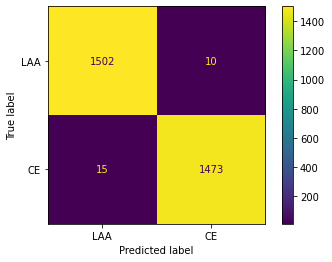

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test, y_pred = np.array(model.test_labels), np.array(model.test_preds)
cm = confusion_matrix(y_test, y_pred.round(), labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["LAA", "CE"])
disp.plot()
plt.show()

In [ ]:
model = LitBGModel().load_from_checkpoint("/content/lightning_logs/version_0/checkpoints/epoch=19-step=4380.ckpt")
model.to_torchscript("bg-classifier.pt")

RecursiveScriptModule(
  original_name=LitBGModel
  (model): RecursiveScriptModule(
    original_name=MobileNetV3
    (conv_stem): RecursiveScriptModule(original_name=Conv2d)
    (bn1): RecursiveScriptModule(
      original_name=BatchNormAct2d
      (drop): RecursiveScriptModule(original_name=Identity)
      (act): RecursiveScriptModule(original_name=Hardswish)
    )
    (blocks): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(
          original_name=DepthwiseSeparableConv
          (conv_dw): RecursiveScriptModule(original_name=Conv2d)
          (bn1): RecursiveScriptModule(
            original_name=BatchNormAct2d
            (drop): RecursiveScriptModule(original_name=Identity)
            (act): RecursiveScriptModule(original_name=ReLU)
          )
          (se): RecursiveScriptModule(
            original_name=SqueezeExcite
            (conv_reduce): RecursiveScriptModule

In [ ]:
!zip -r ./lightning_logs.zip ./lightning_logs

  adding: lightning_logs/ (stored 0%)
  adding: lightning_logs/version_0/ (stored 0%)
  adding: lightning_logs/version_0/checkpoints/ (stored 0%)
  adding: lightning_logs/version_0/checkpoints/epoch=19-step=4380.ckpt (deflated 9%)
  adding: lightning_logs/version_0/hparams.yaml (stored 0%)
  adding: lightning_logs/version_0/events.out.tfevents.1678257626.bf8e56bda12f.415.1 (deflated 30%)
  adding: lightning_logs/version_0/events.out.tfevents.1678256244.bf8e56bda12f.415.0 (deflated 69%)


In [ ]:
%load_ext tensorboard
%tensorboard --logdir=/content/lightning_logs/version_0

<IPython.core.display.Javascript object>